# 필요한 라이브러리

In [28]:
import os
import glob
import cv2
import torch
import torchvision
from PIL import Image
from torchvision import models
import matplotlib.pyplot as plt
import numpy as np
from imageio import imread
from skimage.color import rgb2gray, gray2rgb
import torchvision.transforms as transforms
import torchvision.transforms.functional as F
from PIL import Image
import matplotlib.pyplot as plt

from torchvision.utils import make_grid
from torchvision.io import read_image
from pathlib import Path

from torchvision.transforms.functional import convert_image_dtype

from torchvision.utils import draw_segmentation_masks

# 데이터셋 불러오기

In [13]:
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])


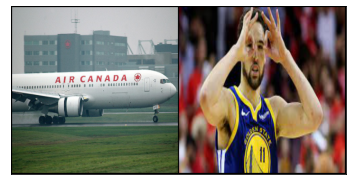

In [15]:
aeroplane_int = read_image(str(Path('data') / 'aeroplane_8.jpg'))
aeroplane_int = transforms.Resize((300, 300))(aeroplane_int)
person_int = read_image(str(Path('data') / 'person_4.jpg'))
person_int = transforms.Resize((300, 300))(person_int)

grid = make_grid([aeroplane_int, person_int])
show(grid)

In [17]:
batch_int = torch.stack([aeroplane_int, person_int])
batch = convert_image_dtype(batch_int, dtype = torch.float)

# 이미지 전처리 수행

In [2]:
data_path = 'data'
device = 'cuda' if torch.cuda.is_available() else 'cpu'

if device == 'cuda':
    transforms_lst = transforms.Compose([
        transforms.Resize(400),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.485, 0.456, 0.406], 
                             std = [0.229, 0.224, 0.225])
    ])
else:
    transforms_lst = transforms.Compose([
        transforms.Resize(680),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.485, 0.456, 0.406], 
                             std = [0.229, 0.224, 0.225])
    ])



['2007_000032.png', '2007_000033.png', '2007_000039.png', '2007_000042.png', '2007_000061.png', '2007_000063.png', '2007_000068.png', '2007_000121.png', '2007_000123.png', '2007_000129.png', '2007_000170.png', '2007_000175.png', '2007_000187.png', '2007_000241.png', '2007_000243.png', '2007_000250.png', '2007_000256.png', '2007_000323.png', '2007_000332.png', '2007_000333.png', '2007_000346.png', '2007_000363.png', '2007_000364.png', '2007_000392.png', '2007_000452.png', '2007_000464.png', '2007_000480.png', '2007_000491.png', '2007_000504.png', '2007_000515.png', '2007_000528.png', '2007_000529.png', '2007_000549.png', '2007_000559.png', '2007_000572.png', '2007_000584.png', '2007_000629.png', '2007_000636.png', '2007_000645.png', '2007_000648.png', '2007_000661.png', '2007_000663.png', '2007_000676.png', '2007_000713.png', '2007_000720.png', '2007_000727.png', '2007_000733.png', '2007_000738.png', '2007_000762.png', '2007_000768.png', '2007_000783.png', '2007_000793.png', '2007_00079

# Segmentation 수행

In [19]:
from torchvision.models.detection import maskrcnn_resnet50_fpn

mask_r_cnn = maskrcnn_resnet50_fpn(pretrained = True, progress = False)
mask_r_cnn = mask_r_cnn.eval()

output = mask_r_cnn(batch)
output

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to C:\Users\rudck/.cache\torch\hub\checkpoints\maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
c:\users\rudck\anaconda3\envs\inpainting\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[{'boxes': tensor([[  0.0000,  48.4193, 295.0119, 207.3632],
          [256.0343,  57.6057, 299.7606,  82.9828],
          [  3.7918, 113.7686, 248.3134, 208.8657]], grad_fn=<StackBackward>),
  'labels': tensor([5, 9, 5]),
  'scores': tensor([0.9978, 0.0657, 0.0545], grad_fn=<IndexBackward>),
  'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]]],
  
  
          [[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]]],
  
  
          [[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 

In [20]:
inst_classes = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

inst_class_to_idx = {cls : idx for (idx, cls) in enumerate(inst_classes)}

In [22]:
len(output)

2

In [24]:
aeroplane_output, person_output = output[0], output[1]
aeroplane_masks, person_masks = aeroplane_output['masks'], person_output['masks']
print(f'shape = {aeroplane_masks.shape}, dtype = {aeroplane_masks.dtype}, '
      f'min = {aeroplane_masks.min()}, max = {aeroplane_masks.max()}')

shape = torch.Size([3, 1, 300, 300]), dtype = torch.float32, min = 0.0, max = 0.9997924566268921


In [26]:
inst_classes = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

inst_class_to_idx = {cls : idx for (idx, cls) in enumerate(inst_classes)}

print('For the first person, the following instances were detected : ')
print([inst_classes[label] for label in aeroplane_output['labels']])

For the first person, the following instances were detected : 
['airplane', 'boat', 'airplane']


shape = torch.Size([3, 1, 300, 300]), dtype = torch.bool


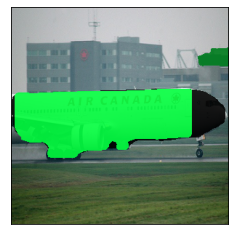

In [29]:
proba_threshold = 0.5
aeroplane_bool_masks = aeroplane_output['masks'] > proba_threshold
print(f'shape = {aeroplane_bool_masks.shape}, dtype = {aeroplane_bool_masks.dtype}')

aeroplane_bool_masks = aeroplane_bool_masks.squeeze(1)

show(draw_segmentation_masks(aeroplane_int, aeroplane_bool_masks, alpha = 0.9))

shape = torch.Size([16, 1, 300, 300]), dtype = torch.bool


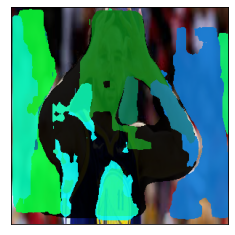

In [30]:
person_bool_masks = person_output['masks'] > proba_threshold
print(f'shape = {person_bool_masks.shape}, dtype = {person_bool_masks.dtype}')

person_bool_masks = person_bool_masks.squeeze(1)

show(draw_segmentation_masks(person_int, person_bool_masks, alpha = 0.9))

# Inpainting 수행